**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

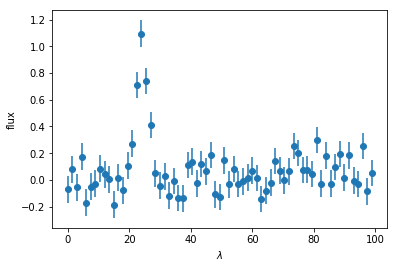

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
df=pd.read_csv('tut_05_data.csv')
x=df['wavelength']
y=df['flux']
plt.errorbar(x,y,yerr=df['sigma'], fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()


2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

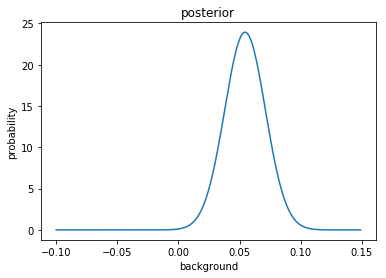

Posterior at edges of parameter space:  5.145873718776107e-18 2.52702008593455e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]
The average of posterior  : 0.05453108678141714
The variance of posterior  : 0.016666664987686954


In [25]:

import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print ('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print ('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print ('The average of posterior  :',bave)
print ('The variance of posterior  :',np.sqrt(variance))


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

In [26]:
#def loglike(b,lo,dl,A):
f = df['flux']
l = df['wavelength']
s = df['sigma']


def Line(ll,lo,dl,A):
    return A*np.exp(-((l-lo)/dl)**2)

#def loglike(A,lo,dl,b):
def log_like(p):
    return 0.5*np.sum( ((f- Line(l,p[1],p[2],p[3]) -p[0]) /s)**2 )



max_values=minimize(log_like,[0.01,21,1.0,0.8])
print(max_values['x'])
print('the values that maximize the parameters are:\n lo=',max_values['x'][1],'\n A=',max_values['x'][3],'\n dl=',max_values['x'][2],'\n ll=',max_values['x'][0])




[ 0.0286165  24.11716857  2.61398138  1.02866768]
the values that maximize the parameters are:
 lo= 24.11716857039785 
 A= 1.028667676702536 
 dl= 2.613981381894805 
 ll= 0.02861650264064383


4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

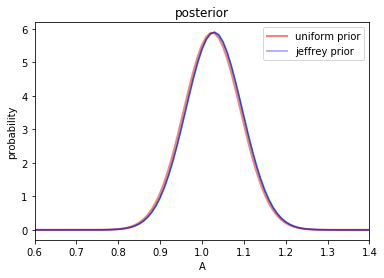

In [27]:
lo_max=max_values['x'][1]
dl_max=max_values['x'][2]
ll_max=max_values['x'][0]

da=0.01
a=np.arange(da,2*max_values['x'][3],da)
likelihood2 = np.empty(len(a))
for i,b in enumerate(a) :
    likelihood2[i] = np.exp(-log_like(np.array([ll_max,lo_max,dl_max,a[i]])))

posterior=likelihood2/np.sum(likelihood2)/da
plt.plot(a,posterior)
plt.xlabel('A parameter')
plt.ylabel('probability')
plt.title('posterior')
                       


likelihoodj = np.empty(len(a))
for i,b in enumerate(a) :
    likelihoodj[i] = np.exp(-log_like(np.array([ll_max,lo_max,dl_max,a[i]])))/a[i]
posteriorj = likelihoodj/np.sum(likelihoodj)/da

plt.plot(a,posteriorj,color='red',label='uniform prior',alpha=0.5,linewidth=2)
plt.plot(a,posterior,color='blue',label='jeffrey prior',alpha=0.3,linewidth=2)
plt.xlabel('A')
plt.ylabel('probability')
plt.title('posterior')
plt.legend(loc='upper right')
plt.xlim(0.6,1.4)
plt.show()

5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

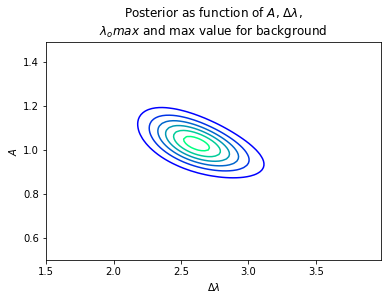

In [5]:
#####
ddl=max_values['x'][2]/100
dA=0.01
A_max=max_values['x'][3]
x=np.arange(1.5,4,ddl)
y=np.arange(0.5,1.5,dA)
posterior2d = np.empty([len(y),len(x)])
for i, A in enumerate(y) :
    for j,dl in enumerate(x):
        par=[ll_max,lo_max,dl,A]
        posterior2d[i,j] = np.exp(-log_like(par))


X,Y=np.meshgrid(x,y)
post2d=posterior2d/np.sum(posterior2d)/ddl/dA

plt.contour(X,Y,post2d,cmap='winter')
plt.ylabel('$A$')
plt.xlabel('$\Delta \lambda$')
plt.title('Posterior as function of $A$, $\Delta \lambda$, \n$\lambda_o max$ and max value for background')
plt.show()





6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

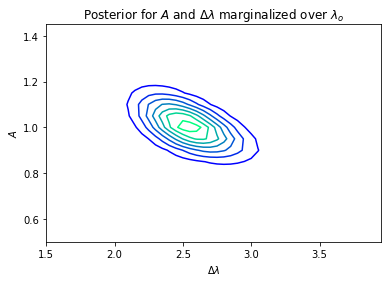

In [28]:
#####
## the maximum likelihood value for the background is bmax
## p = [A,dl,lo,b]

ddl=0.05
dA=0.05

x=np.arange(1.5,4,ddl)
y=np.arange(0.5,1.5,dA)
def newpost(lo,b,dl,A):
    return np.exp(-log_like(np.array([bmax[0],lo,dl,A])))

def marg_post(dl,A):
    marg_post=quad(newpost,10,30,args=(bmax[0],dl,A))
    return marg_post[0]

post2d_marg=np.empty([len(y),len(x)])
for i, A in enumerate(y) :
    for j,dl in enumerate(x):
        post2d_marg[i,j] = marg_post(dl,A)

X,Y=np.meshgrid(x,y)
plt.contour(X,Y,post2d_marg,cmap='winter')
plt.ylabel('$A$')
plt.xlabel('$\Delta \lambda$')
plt.title('Posterior for $A$ and $\Delta \lambda$ marginalized over $\lambda_o$')
plt.show()

7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.

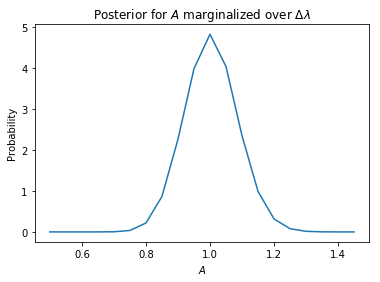

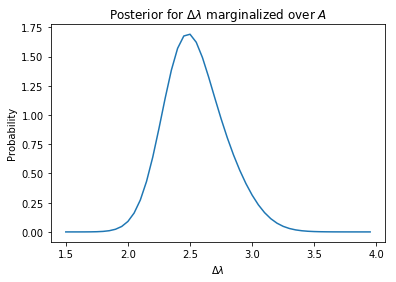

In [29]:
#####  1D Posterior for A marginalized over dl
def post_A(A):
    return quad(marg_post,0,10,args=(A,))[0]
post_1d=np.empty(len(y))
for i in range(len(y)):
    post_1d[i]=post_A(y[i])
post_1d=post_1d/np.sum(post_1d)/dA

plt.plot(y,post_1d)
plt.xlabel('$A$')
plt.ylabel('Probability')
plt.title('Posterior for $A$ marginalized over $\Delta \lambda$')
plt.show()

###  1D Posterior for dl marginalized over A
def newposterior(A,dl):
    return marg_post(dl,A)

def post_dl(dl):
    return quad(newposterior,0,5,args=(dl,))[0]
p=np.empty(len(x))
for j in range(len(x)):
    p[j]=post_dl(x[j])
p=p/np.sum(p)/ddl

plt.plot(x,p)
plt.xlabel('$\Delta \lambda$')
plt.ylabel('Probability')
plt.title('Posterior for $\Delta \lambda$ marginalized over $A$')
plt.show()



8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.

9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 

maximum likelihood estimate of A after marginalizing over λo and then over $\Delta \lambda$
